In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7fdabc66e700>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2670>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce26a0>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2730>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce27c0>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2880>,
 'nv': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2910>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce29a0>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2af0>,
 'lat_bnds': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2b50>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2be0>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2ca0>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2d00>,
 'tpa_correction': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2d90>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7fda43ce2e20>,
 'longitude': <scipy.io._n

In [3]:
lat = f.variables['latitude'].data[60:82]
long = f.variables['longitude'].data[10:40]
vel_x = f.variables['ugos'].data.squeeze()
print(vel_x.shape[0])
vel_y = f.variables['vgos'].data.squeeze()
print(vel_y.shape)
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)[60:82,10:40]
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)[60:82,10:40]

321
(321, 81)


dist=0.4872410263434801 winding_angle=-0.10043810330212644 closed=True


<IPython.core.display.Javascript object>


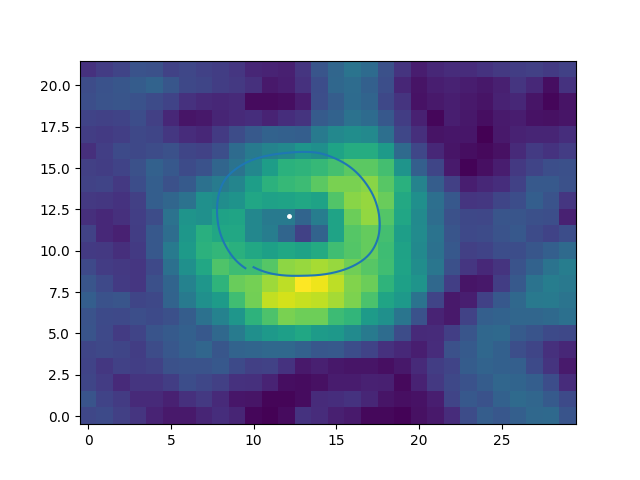

In [13]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.spatial.distance import euclidean


# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
j = np.linspace(0, n, n)
i = np.linspace(0, m, m)
method = "linear"

interp_vel_x = RegularGridInterpolator((i, j), imputed_vel_x, method=method)
interp_vel_y = RegularGridInterpolator((i, j), imputed_vel_y, method=method)

def rhs(t, x):
    return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    
def streamline(i,j, *, steps, step_size, dist_tol, winding_tol):
    #print(i,j, flush=True)
    winding_angle = 0
    theta_prev = 0
    closed = False
    
    start_i = i
    start_j = j
    
    trajectory = [[i,j]]
    
    for k in range(steps):
        try:
            v = rhs(0,[i,j])
        except:
            break
        
        # integrate
        i += step_size*v[1]
        j += step_size*v[0]
        
        theta = np.arctan2(v[1], v[0])
        
        if k > 1:
            winding_angle += theta - theta_prev
           
        if k > 500 and (dist:=euclidean([i,j],[start_i,start_j])) < dist_tol:
            closed = True
            break
            
            
        theta_prev = theta
        trajectory.append([i,j])
    
    if (winding_angle % (2*np.pi) < winding_tol or winding_angle % (-2*np.pi) < winding_tol) and closed:
        print(f"{dist=} {winding_angle=} {closed=}")
    return np.asarray(trajectory).T

sol = streamline(9,10, steps=2000, step_size=0.1, dist_tol=0.5, winding_tol=0.3)
eddy = np.mean(sol, axis=-1)

plt.figure()
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower',)
plt.plot(sol[1], sol[0])
plt.plot(eddy[1], eddy[0]-0.5, 'w.', markersize=5, label="Eddy Centre")

<IPython.core.display.Javascript object>


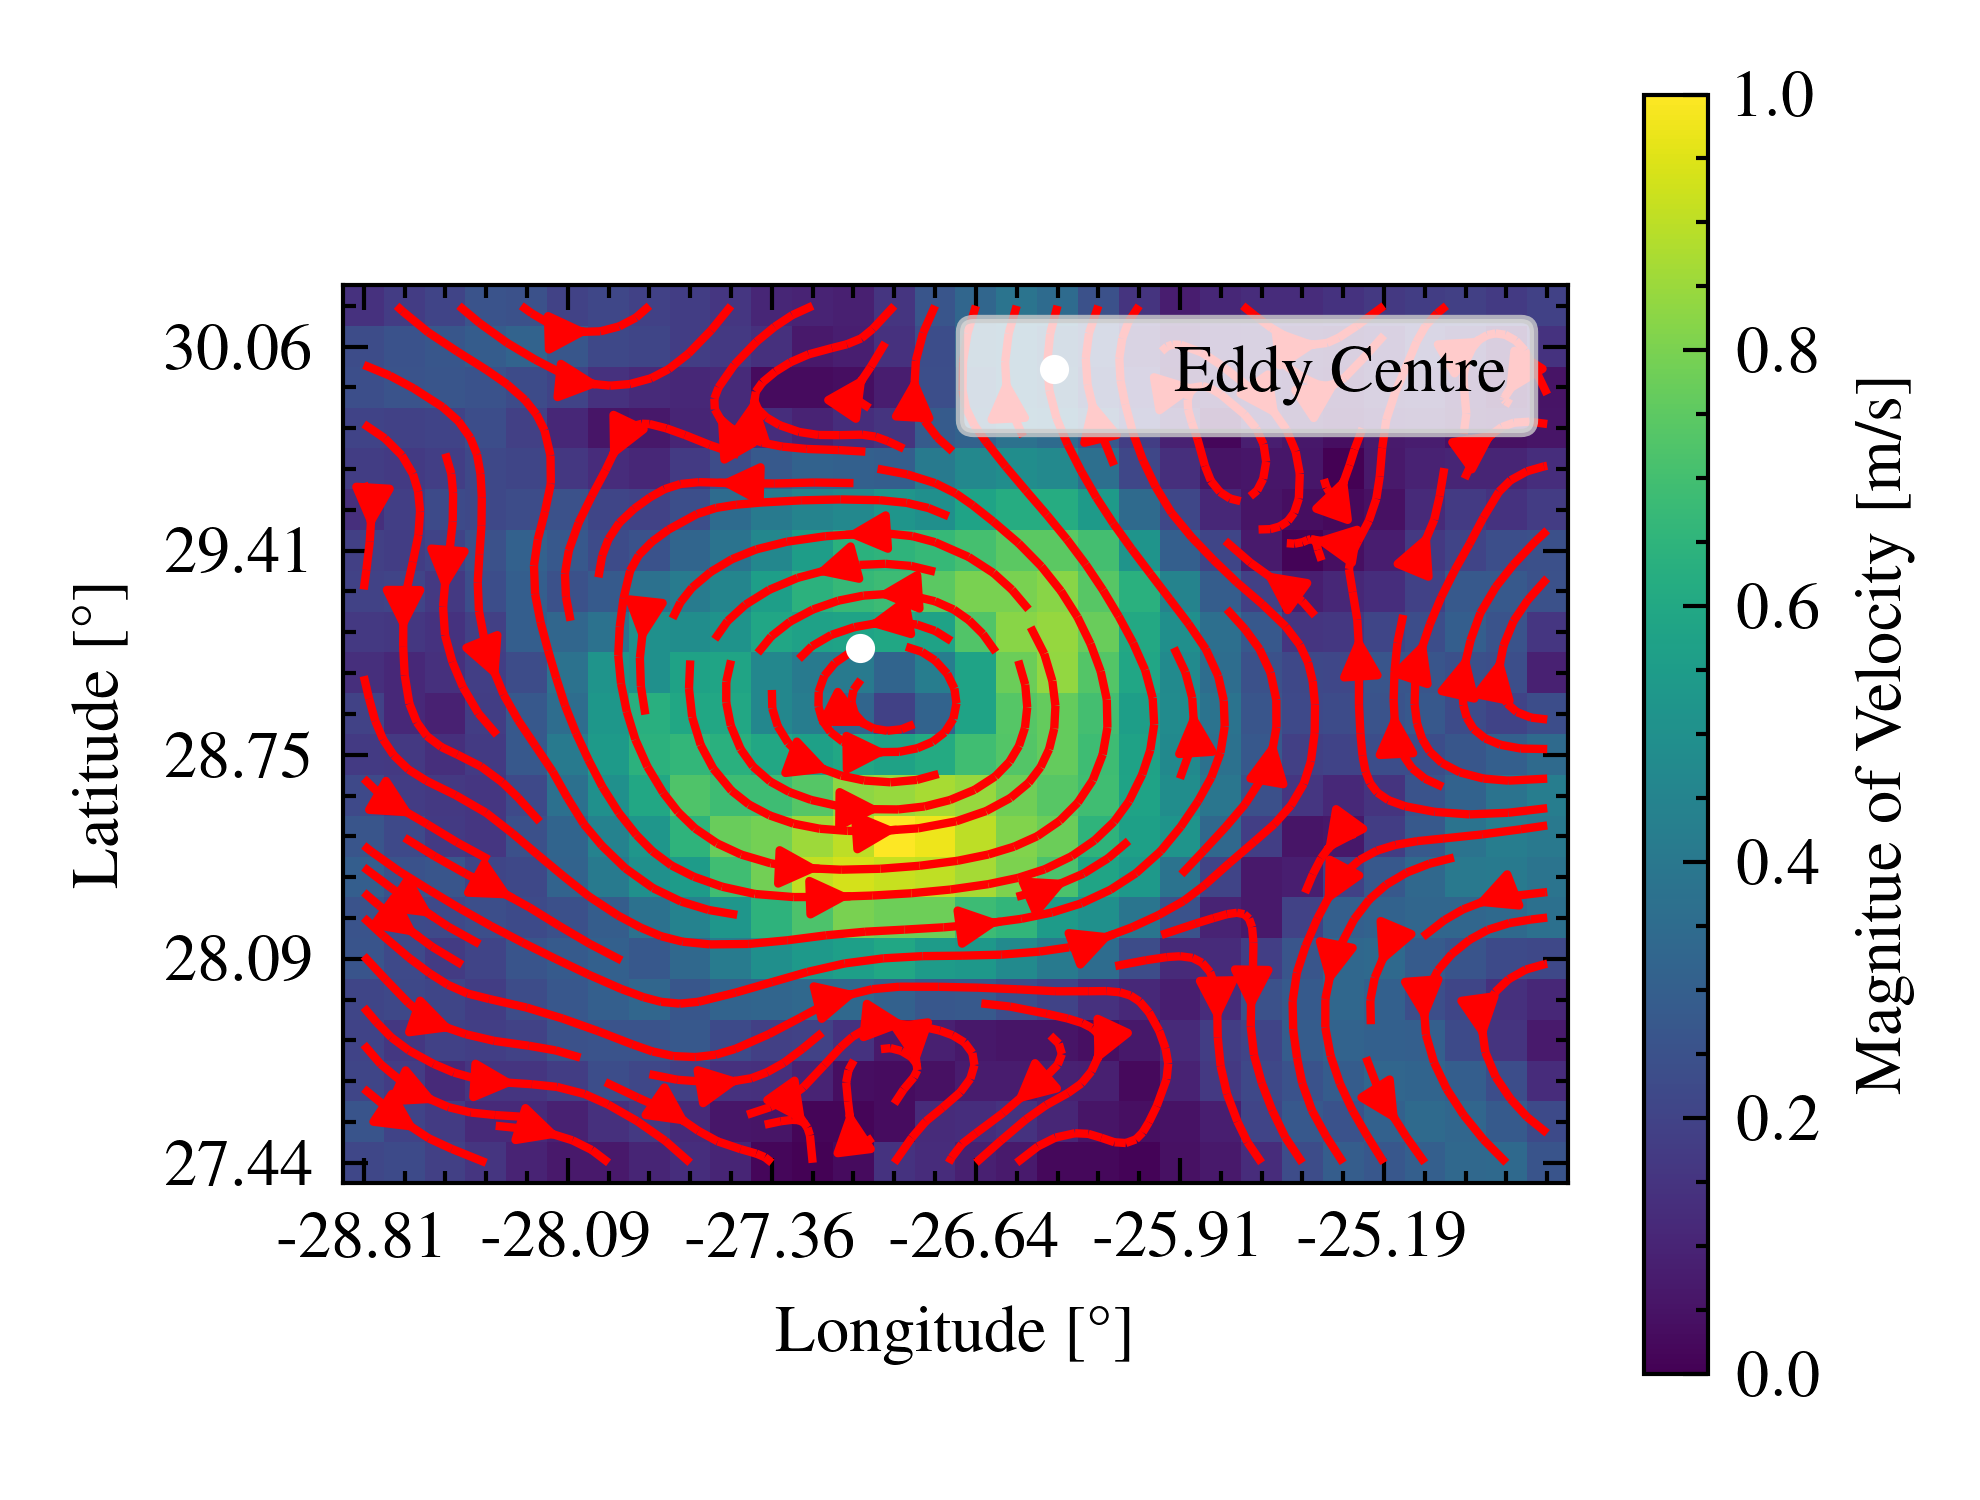

In [15]:

plt.style.use(['science','ieee'])
plt.figure()
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower',)
y = np.arange(0, imputed_vel_x.shape[0])
x = np.arange(0, imputed_vel_x.shape[1])
X, Y = np.meshgrid(x, y)
plt.streamplot(X,Y,imputed_vel_x, imputed_vel_y, density=1, color='r')
plt.plot(eddy[1], eddy[0], 'w.', markersize=5, label="Eddy Centre")
plt.legend(loc='upper right', frameon=True)
cbar = plt.colorbar()
cbar.set_label("Magnitue of Velocity [m/s]")
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
current_xticks = plt.gca().get_xticks()[1:-1]
plt.xticks(current_xticks, np.around(np.linspace(long.min(),long.max(), len(current_xticks)), 2))
current_yticks = plt.gca().get_yticks()[1:-1]
plt.yticks(current_yticks, np.around(np.linspace(lat.min(),lat.max(), len(current_yticks)), 2))
plt.tight_layout()
plt.savefig("figures/windingangle.pdf")